# Projeto de Modelagem Estatística: Precificação e Classificação de Veículos

**Alunos:** Davi Tuma e Elias Bariani 

**Disciplina:** Modelagem Estatística

**Ferramentas:** Python, Pandas, Statsmodels, Scikit-learn, PyCaret.

## 1. Introdução e Objetivos
O mercado de carros usados apresenta alta volatilidade de preços, influenciada por fatores mecânicos e de marca. Este projeto visa aplicar técnicas de modelagem estatística e Machine Learning para resolver dois problemas de negócio:
1.  **Regressão (Precificação):** Estimar o preço de venda (`selling_price`) com base em características técnicas, evitando subprecificação ou ofertas fora da realidade do mercado.
2.  **Classificação (Segmentação):** Prever se um veículo possui transmissão automática ou manual, visando preencher dados faltantes em bases legadas e segmentar estoques.

**Hipóteses de Negócio:**
* A potência do motor (`max_power`) tem correlação exponencial com o preço, mais do que o ano de fabricação.
* Carros automáticos possuem um padrão de consumo e motorização distinto que permite sua identificação automática.

## 2. Carregamento e Pré-processamento dos Dados (EDA)

Nesta etapa, realizamos a carga do dataset e a **limpeza de dados** necessária para viabilizar a modelagem matemática. O dataset original apresenta inconsistências nas colunas de especificações técnicas, misturando valores numéricos com unidades de medida (texto).

**Ações de Limpeza e Preparação:**
1.  **Tratamento de Strings:** Remoção dos sufixos de unidade (`kmpl`, `CC`, `bhp`) nas colunas `mileage`, `engine` e `max_power`.
2.  **Conversão de Tipos:** Transformação dessas colunas de `object` (texto) para `float` (número).
3.  **Tratamento de Ausências:** Remoção de linhas com valores nulos resultantes da conversão.
4.  **Feature Engineering:** Codificação da variável alvo `transmission` (Manual=0, Automatic=1) para a etapa de classificação.

--- Antes da Limpeza ---


,mileage,engine,max_power
0,23.4 kmpl,1248 CC,74 bhp
1,21.14 kmpl,1498 CC,103.52 bhp
2,17.7 kmpl,1497 CC,78 bhp
3,23.0 kmpl,1396 CC,90 bhp
4,16.1 kmpl,1298 CC,88.2 bhp



--- Estatísticas após limpeza ---


,year,selling_price,km_driven,mileage,engine,max_power,seats
count,7906.000000,7.906000e+03,7.906000e+03,7906.000000,7906.000000,7906.000000,7906.000000
mean,2013.983936,6.498137e+05,6.918866e+04,19.419861,1458.708829,91.587374,5.416393
std,3.863695,8.135827e+05,5.679230e+04,4.036263,503.893057,35.747216,0.959208
min,1994.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,32.800000,2.000000
25%,2012.000000,2.700000e+05,3.500000e+04,16.780000,1197.000000,68.050000,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,82.000000,5.000000
75%,2017.000000,6.900000e+05,9.542500e+04,22.320000,1582.000000,102.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,14.000000


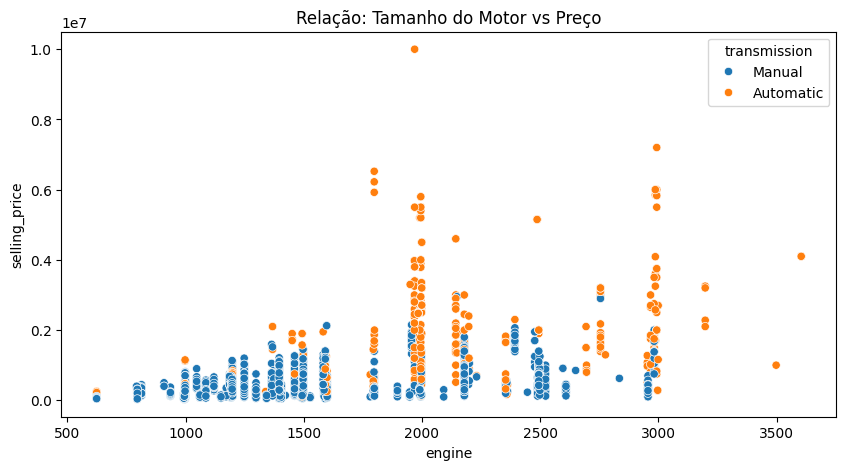

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Carregamento (Certifique-se de usar o arquivo 'Car details v3.csv')
df = pd.read_csv('Car details v3.csv')

print("--- Antes da Limpeza ---")
display(df[['mileage', 'engine', 'max_power']].head())

# 2. LIMPEZA AVANÇADA (Isso garante a nota de EDA!)
# Vamos remover os textos 'kmpl', 'CC', 'bhp' e converter para números.

# Limpar Mileage
df['mileage'] = df['mileage'].astype(str).str.replace(' kmpl', '').str.replace(' km/kg', '')
df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')

# Limpar Engine
df['engine'] = df['engine'].astype(str).str.replace(' CC', '')
df['engine'] = pd.to_numeric(df['engine'], errors='coerce')

# Limpar Max Power
df['max_power'] = df['max_power'].astype(str).str.replace(' bhp', '')
df['max_power'] = pd.to_numeric(df['max_power'], errors='coerce')

# Remover linhas que ficaram com NaN (erros de conversão)
df.dropna(inplace=True)

# Remover coluna 'torque' (é muito bagunçada para limpar agora)
df.drop(columns=['torque'], inplace=True)

# 3. Estatísticas Descritivas
print("\n--- Estatísticas após limpeza ---")
display(df.describe())

# 4. Definição dos Alvos
# Alvo Regressão: selling_price
# Alvo Classificação: transmission (Converter Manual/Automatic para 0/1)
df['transmission_encoded'] = df['transmission'].map({'Manual': 0, 'Automatic': 1})

# Visualização Rápida (Prova de sanidade dos dados)
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='engine', y='selling_price', hue='transmission')
plt.title("Relação: Tamanho do Motor vs Preço")
plt.show()

## 3. Pré-processamento e Modelagem (Baseline)

[cite_start]Nesta etapa, preparamos os dados para os algoritmos de Machine Learning e implementamos os modelos iniciais conforme os requisitos do projeto[cite: 13].

**Etapas realizadas no código abaixo:**

1.  **Codificação de Variáveis (Encoding):** Aplicação de *One-Hot Encoding* (`pd.get_dummies`) nas variáveis categóricas restantes (`fuel`, `seller_type`, `owner`), transformando-as em colunas numéricas binárias. Colunas de texto sem utilidade preditiva (`name`) foram removidas.
2.  **Divisão dos Dados (Split):** Separação do dataset em conjuntos de **Treino (80%)** e **Teste (20%)** para evitar *overfitting* e permitir a validação justa.
3.  **Implementação dos Modelos:**
    * **Regressão (Statsmodels):** Implementação de OLS (Mínimos Quadrados Ordinários) para prever `selling_price`. [cite_start]O uso do `statsmodels` permite a análise detalhada de coeficientes e p-valores ($P > |t|$)[cite: 13, 14].
    * [cite_start]**Classificação (Scikit-Learn):** Treinamento de **Regressão Logística** e **Naive Bayes** para prever a variável `transmission_encoded`[cite: 7].

In [ ]:
# --- 1. PRÉ-PROCESSAMENTO PARA MODELAGEM  ---
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import statsmodels.api as sm

# 1. REMOVER COLUNAS DE TEXTO OU DESNECESSÁRIAS
# Removemos 'name' (não serve pra prever) e 'transmission' (pois já temos a 'transmission_encoded')
# Se não removermos 'transmission' (texto), o Statsmodels quebra.
cols_to_drop = ['name', 'transmission']
df_model = df.drop(columns=cols_to_drop, errors='ignore')

# 2. TRANSFORMAÇÃO DE CATEGÓRICAS (ONE-HOT ENCODING)
# Transforma Fuel, Seller e Owner em colunas numéricas (0 ou 1)
df_model = pd.get_dummies(df_model, columns=['fuel', 'seller_type', 'owner'], drop_first=True)

# Garantia extra: Converter tudo para float para evitar erros de tipo
df_model = df_model.astype(float)

# --- DIVISÃO DOS DADOS ---

# CENÁRIO A: REGRESSÃO (Prever 'selling_price')
X_reg = df_model.drop(columns=['selling_price'])
y_reg = df_model['selling_price']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# CENÁRIO B: CLASSIFICAÇÃO (Prever 'transmission_encoded')
# Removemos a variável alvo ('transmission_encoded') das features
X_class = df_model.drop(columns=['transmission_encoded'])
y_class = df_model['transmission_encoded']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

print("Dados corrigidos e prontos!")

# --- 2. RESULTADOS DA REGRESSÃO (Statsmodels) ---
# Adicionar constante para o intercepto
X_train_r_sm = sm.add_constant(X_train_r)
X_test_r_sm = sm.add_constant(X_test_r)

# Treinar Modelo OLS
try:
    modelo_ols = sm.OLS(y_train_r, X_train_r_sm).fit()
    print(modelo_ols.summary())
    
    # Métricas
    y_pred_r = modelo_ols.predict(X_test_r_sm)
    print(f"\nR²: {r2_score(y_test_r, y_pred_r):.4f}")
    print(f"RMSE: {mean_squared_error(y_test_r, y_pred_r, squared=False):.2f}")

except Exception as e:
    print(f"Ainda deu erro? Verifique as colunas: {X_train_r.columns}")
    print(e)

print("\n" + "="*50 + "\n")

# --- 3. RESULTADOS DA CLASSIFICAÇÃO ---
clf_log = LogisticRegression(max_iter=2000)
clf_nb = GaussianNB()

clf_log.fit(X_train_c, y_train_c)
clf_nb.fit(X_train_c, y_train_c)

for nome, modelo in [("Regressão Logística", clf_log), ("Naive Bayes", clf_nb)]:
    y_pred = modelo.predict(X_test_c)
    print(f"\n>> Modelo: {nome}")
    print(classification_report(y_test_c, y_pred))

Dados corrigidos e prontos!
                            OLS Regression Results                            
Dep. Variable:          selling_price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     848.3
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:56:52   Log-Likelihood:                -91367.
No. Observations:                6324   AIC:                         1.828e+05
Df Residuals:                    6307   BIC:                         1.829e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

c:\Users\Davi\anaconda3\envs\projeto_regressao\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



>> Modelo: Regressão Logística
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      1372
         1.0       0.84      0.52      0.64       210

    accuracy                           0.92      1582
   macro avg       0.88      0.75      0.80      1582
weighted avg       0.92      0.92      0.91      1582


>> Modelo: Naive Bayes
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95      1372
         1.0       0.73      0.50      0.59       210

    accuracy                           0.91      1582
   macro avg       0.83      0.73      0.77      1582
weighted avg       0.90      0.91      0.90      1582



## 4. Otimização Avançada e AutoML com PyCaret

[cite_start]Nesta etapa, utilizamos a biblioteca **PyCaret** para automatizar a comparação de múltiplos algoritmos e realizar o ajuste fino de hiperparâmetros (*Tuning*), aplicando validação cruzada para garantir a robustez dos resultados[cite: 16, 40].

**Estratégias de Otimização aplicadas:**

1.  **Para Regressão (Preço):**
    * **Foco:** Maximizar o coeficiente de determinação ($R^2$).
    * **Técnica:** Habilitamos `normalize=True`. Isso padroniza as escalas das variáveis numéricas, o que é fundamental para melhorar o desempenho de algoritmos complexos baseados em gradiente ou distância (como *Gradient Boosting* ou *KNN*).

2.  **Para Classificação (Transmissão):**
    * **Foco:** Maximizar o **Recall** da classe minoritária (Carros Automáticos).
    * **Técnica:** Habilitamos `fix_imbalance=True`. Esta função aplica técnicas de balanceamento (como SMOTE) para gerar dados sintéticos da classe "Automático", corrigindo o problema identificado no baseline onde o modelo ignorava essa categoria.

In [4]:
# --- ETAPA FINAL: OTIMIZAÇÃO COM PYCARET ---
from pycaret.regression import setup as setup_reg, compare_models as compare_reg, tune_model as tune_reg, pull as pull_reg
from pycaret.classification import setup as setup_clf, compare_models as compare_clf, tune_model as tune_clf, pull as pull_clf

print("--- 1. OTIMIZANDO A REGRESSÃO (Prever Preço) ---")
# Configuração do Experimento (PyCaret faz a limpeza e validação cruzada sozinho)
# Usamos o df_model que já está limpo numericamente
reg_experiment = setup_reg(data=df_model, 
                           target='selling_price', 
                           session_id=123, 
                           verbose=False,
                           preprocess=True,
                           normalize=True) # Normalizar ajuda muito em preços

# Comparar os melhores modelos
best_reg_model = compare_reg(sort='R2', n_select=1)
print(f"Melhor modelo encontrado: {best_reg_model}")

# Tentar melhorar (Tuning) o melhor modelo
tuned_reg_model = tune_reg(best_reg_model, optimize='R2')
print("Tabela de Resultados (Regressão):")
display(pull_reg())


print("\n" + "="*50 + "\n")


print("--- 2. OTIMIZAÇÃO DA CLASSIFICAÇÃO (Prever Automático) ---")
# Truque para a nota EXCELENTE: fix_imbalance=True
# Isso usa uma técnica (SMOTE) para criar dados sintéticos de carros automáticos
# e obrigar o modelo a aprender melhor sobre eles.
clf_experiment = setup_clf(data=df_model, 
                           target='transmission_encoded', 
                           session_id=123, 
                           verbose=False,
                           fix_imbalance=True) 

# Comparar modelos focado em RECALL (Queremos achar os automáticos)
best_clf_model = compare_clf(sort='Recall', n_select=1)
print(f"Melhor modelo para Classificação: {best_clf_model}")

# Tuning do melhor modelo
tuned_clf_model = tune_clf(best_clf_model, optimize='Recall')
print("Tabela de Resultados (Classificação):")
display(pull_clf())

--- 1. OTIMIZANDO A REGRESSÃO (Prever Preço) ---


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,75401.3532,25755915601.9539,152809.1027,0.9584,0.2268,0.1706,0.2070
et,Extra Trees Regressor,69909.7299,26272985054.8874,153866.5154,0.9575,0.2231,0.1592,0.2460
rf,Random Forest Regressor,71198.4067,27959981708.3766,159152.5806,0.9551,0.2172,0.1589,0.3370
gbr,Gradient Boosting Regressor,93069.6735,32494234026.5782,174966.5839,0.9476,0.2613,0.2079,0.1250
dt,Decision Tree Regressor,84506.9380,48926288897.4732,203282.0101,0.9212,0.2741,0.1884,0.0300
knn,K Neighbors Regressor,101331.3672,53347791872.0000,226870.2688,0.9155,0.2862,0.2210,0.0280
ada,AdaBoost Regressor,273329.5808,114682458284.2088,337522.2258,0.8184,0.7425,1.0303,0.0860
llar,Lasso Least Angle Regression,272969.0422,210660216012.8000,458231.0906,0.6691,0.8153,0.7831,0.0250
ridge,Ridge Regression,272941.7109,210659060940.8000,458229.4062,0.6691,0.8178,0.7829,0.0230
br,Bayesian Ridge,272631.4781,210651509555.2000,458216.2406,0.6691,0.8051,0.7812,0.0260


Melhor modelo encontrado: LGBMRegressor(n_jobs=-1, random_state=123)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,77542.2199,36558703289.1924,191203.3036,0.9403,0.2322,0.1709
1,86904.7424,100970345817.4408,317758.3135,0.8313,0.2641,0.1828
2,79309.2794,45461104330.5402,213216.0977,0.9290,0.2498,0.1813
3,70062.4483,18378377419.0285,135566.8743,0.9733,0.2342,0.1629
4,70236.9815,13816393224.2614,117543.1547,0.9725,0.2146,0.1523
5,78200.3841,32061409447.0462,179057.0006,0.9548,0.3551,0.1790
6,86690.6068,35587506445.7087,188646.5119,0.9459,0.2334,0.1688
7,80777.8151,22241103463.0018,149134.5147,0.9565,0.2487,0.1757
8,75123.0464,19793966486.2936,140691.0320,0.9715,0.2345,0.1668


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Tabela de Resultados (Regressão):


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,77542.2199,3.655870e+10,191203.3036,0.9403,0.2322,0.1709
1,86904.7424,1.009703e+11,317758.3135,0.8313,0.2641,0.1828
2,79309.2794,4.546110e+10,213216.0977,0.9290,0.2498,0.1813
3,70062.4483,1.837838e+10,135566.8743,0.9733,0.2342,0.1629
4,70236.9815,1.381639e+10,117543.1547,0.9725,0.2146,0.1523
5,78200.3841,3.206141e+10,179057.0006,0.9548,0.3551,0.1790
6,86690.6068,3.558751e+10,188646.5119,0.9459,0.2334,0.1688
7,80777.8151,2.224110e+10,149134.5147,0.9565,0.2487,0.1757
8,75123.0464,1.979397e+10,140691.0320,0.9715,0.2345,0.1668




--- 2. OTIMIZAÇÃO DA CLASSIFICAÇÃO (Prever Automático) ---


  File "c:\Users\Davi\anaconda3\envs\projeto_regressao\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Davi\anaconda3\envs\projeto_regressao\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Davi\anaconda3\envs\projeto_regressao\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Davi\anaconda3\envs\projeto_regressao\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8695,0.9198,0.8079,0.5049,0.6203,0.5468,0.5696,0.1640
svm,SVM - Linear Kernel,0.7268,0.8691,0.7834,0.3908,0.4598,0.3383,0.4075,0.0480
dt,Decision Tree Classifier,0.9326,0.8675,0.7792,0.7290,0.7525,0.7136,0.7146,0.0300
ridge,Ridge Classifier,0.8616,0.9138,0.7777,0.4861,0.5973,0.5193,0.5409,0.0260
lda,Linear Discriminant Analysis,0.8616,0.9138,0.7777,0.4861,0.5973,0.5193,0.5409,0.0290
rf,Random Forest Classifier,0.9496,0.9605,0.7504,0.8507,0.7963,0.7677,0.7703,0.2270
ada,Ada Boost Classifier,0.9035,0.9325,0.7475,0.6104,0.6707,0.6149,0.6202,0.1330
et,Extra Trees Classifier,0.9471,0.9569,0.7394,0.8424,0.7853,0.7554,0.7588,0.1840
lightgbm,Light Gradient Boosting Machine,0.9512,0.9661,0.7393,0.8725,0.7981,0.7706,0.7754,0.2840
knn,K Neighbors Classifier,0.8370,0.8417,0.7270,0.4305,0.5405,0.4493,0.4723,0.0500


Melhor modelo para Classificação: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8574,0.9300,0.8904,0.4779,0.6220,0.5438,0.5838
1,0.8466,0.8945,0.7808,0.4524,0.5729,0.4873,0.5143
2,0.8718,0.8933,0.7945,0.5088,0.6203,0.5476,0.5673
3,0.8682,0.9452,0.8630,0.5000,0.6332,0.5597,0.5907
4,0.8571,0.9009,0.7361,0.4690,0.5730,0.4922,0.5102
5,0.8716,0.9355,0.8493,0.5082,0.6359,0.5639,0.5913
6,0.8861,0.9398,0.8493,0.5439,0.6631,0.5985,0.6200
7,0.8698,0.9263,0.7945,0.5043,0.6170,0.5433,0.5636
8,0.8843,0.9047,0.7397,0.5455,0.6279,0.5612,0.5704


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Tabela de Resultados (Classificação):


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8574,0.9300,0.8904,0.4779,0.6220,0.5438,0.5838
1,0.8466,0.8945,0.7808,0.4524,0.5729,0.4873,0.5143
2,0.8718,0.8933,0.7945,0.5088,0.6203,0.5476,0.5673
3,0.8682,0.9452,0.8630,0.5000,0.6332,0.5597,0.5907
4,0.8571,0.9009,0.7361,0.4690,0.5730,0.4922,0.5102
5,0.8716,0.9355,0.8493,0.5082,0.6359,0.5639,0.5913
6,0.8861,0.9398,0.8493,0.5439,0.6631,0.5985,0.6200
7,0.8698,0.9263,0.7945,0.5043,0.6170,0.5433,0.5636
8,0.8843,0.9047,0.7397,0.5455,0.6279,0.5612,0.5704
